In [2]:
import numpy as np
import torch 
import sys
sys.path.append("../")
from model_dynamic_streaming_tensor import Streaming_Dynammic_Tensor_CP
import utils_streaming
import tqdm
import yaml
torch.random.manual_seed(300)
import matplotlib.pyplot as plt


path = "./config_server_CP.yaml"
with open(path, "r") as f:
    config = yaml.safe_load(f)

data_file = config["data_path"]


hyper_dict = utils_streaming.make_hyper_dict(config)
hyper_dict["R_U"] = 3

data_dict = utils_streaming.make_data_dict(hyper_dict,data_file)

INNER_ITER = hyper_dict["INNER_ITER"]
THRE = hyper_dict["THRE"]

model = Streaming_Dynammic_Tensor_CP(hyper_dict, data_dict)
model.reset()
# model.E_tau = 2


use device: cpu


In [3]:
for T_id in tqdm.tqdm(range(len(model.unique_train_time))):

    """ init_msg->filter_update->msg_approx->filter_update/post_update"""

    T = model.unique_train_time[T_id]
    model.track_envloved_objects(T_id)
    model.filter_predict(T)
    model.msg_llk_init()

    for inner_it in range(INNER_ITER):
        

        old_post = utils_streaming.get_post(model, T)
        flag = (inner_it == (INNER_ITER - 1))

        model.msg_U_m = []
        model.msg_U_V = []

        if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True: 
            for mode in range(model.nmods):
                model.msg_approx_U(T, mode)
                model.filter_update(T, mode, flag)

        else: 
            for mode in range(model.nmods):
                model.msg_approx_U(T, mode)

            for mode in range(model.nmods):
                model.filter_update(T, mode, flag)

        model.msg_approx_tau(T)
        model.post_update_tau(T)

        new_post = utils_streaming.get_post(model, T)

        relative_change = torch.square(new_post -
                                    old_post).sum() / old_post.norm()

        if flag:
            '''not converge till the MAX ITERATION'''
            pass
        elif relative_change < THRE:
            '''early converge'''

            if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True: 
                for mode in range(model.nmods):
                    model.msg_approx_U(T, mode)
                    model.filter_update(T, mode, True)

            else: 
                for mode in range(model.nmods):
                    model.msg_approx_U(T, mode)

                for mode in range(model.nmods):
                    model.filter_update(T, mode, True)

            model.msg_approx_tau(T)
            model.post_update_tau(T)

            break


model.smooth()
model.get_post_U()

pred, test_result = model.model_test(model.te_ind, model.te_y,
                                    model.test_time_ind)

print(" test_error after smooth", test_result['rmse'])




100%|██████████| 1000/1000 [00:23<00:00, 42.09it/s] 


 test_error after smooth tensor(0.1705, dtype=torch.float64)


In [7]:


U1_traj_mean = model.post_U_m[0].squeeze().cpu().numpy()
U2_traj_mean = model.post_U_m[1].squeeze().cpu().numpy()
U3_traj_mean = model.post_U_m[2].squeeze().cpu().numpy()


U1_traj_v = model.post_U_v[0].squeeze().cpu().numpy()
U2_traj_v = model.post_U_v[1].squeeze().cpu().numpy()
U3_traj_v = model.post_U_v[2].squeeze().cpu().numpy()


U_traj_m = [U1_traj_mean,U2_traj_mean,U3_traj_mean]
U_traj_v = [U1_traj_v,U2_traj_v,U3_traj_v]



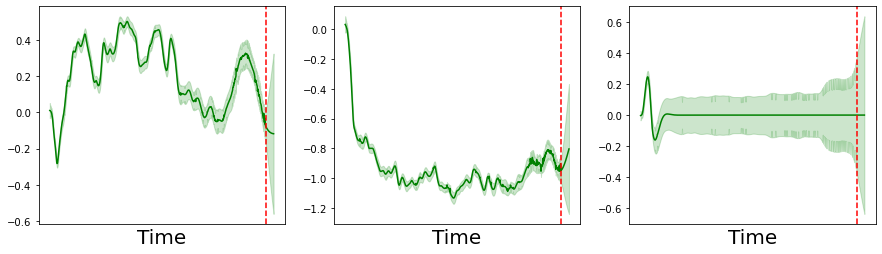

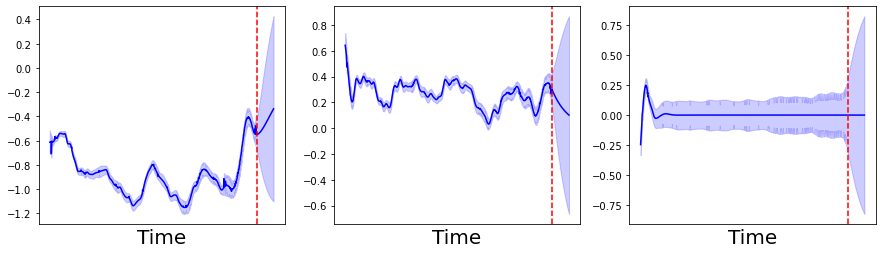

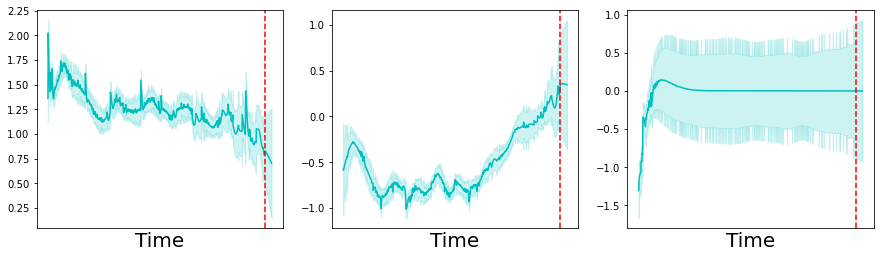

In [6]:
def plot_trai_r(target_mode,target_node, r_list, color='b'):
    num_figure = len(r_list)
    # use subplots to plot the figure
    plt.subplots( 1,num_figure,figsize=(15, 4))
    
    target_traj = U_traj_m[target_mode]
    target_traj_v = U_traj_v[target_mode]
    for i in range(num_figure):
        r=r_list[i]
        plt.subplot( 1,num_figure, i + 1)
        plt.plot(model.time_uni, target_traj[target_node[0], r,:],color=color)
        
        # plot the variance
        plt.fill_between(model.time_uni, target_traj[target_node[0],r, :] - np.sqrt(target_traj_v[target_node[0],r,r, :]), target_traj[target_node[0], r,:] + np.sqrt(target_traj_v[target_node[0],r,r, :]), alpha=0.2,color=color)
        
        # find the time this node last show in trainig 
        last_ind = np.where(model.tr_ind[:,target_mode]==target_node[0])[0][-1]
        last_show_time = model.train_time_ind[last_ind]/1000
        plt.axvline(x=last_show_time, color='r', linestyle='--')
        
        
        
        # plt.title('node ' + str(target_node[i]))
        plt.xlabel('Time',fontsize=20)
        plt.xticks([], [])
        

r_list=[0,1,2]

target_mode = 0
target_node = [2]
plot_trai_r(target_mode,target_node, r_list,'g')

target_mode = 1
target_node = [0]
r_list=[0,1,2]
plot_trai_r(target_mode,target_node, r_list,'b')

target_mode = 2
target_node = [2]
plot_trai_r(target_mode,target_node, r_list,'c')